In [1]:
# imports
from supervisor import GWNETPredictor
from STNET.dataset import DataModule
from libs import utils
from pytorch_lightning import Trainer
import pandas as pd
import yaml

In [2]:
# dataset and checkpoint
dataset = 'la'
checkpoint = 'experiments/la/Forward-backward-adaptive/checkpoints/epoch=65-step=24749.ckpt'

In [3]:
# load model from the checkpoint
dm = DataModule(dataset)
dm.prepare_data()


model = GWNETPredictor.load_from_checkpoint(
    checkpoint, scaler=dm.get_scaler(), A=dm.get_adj())

# print hyper parameters
print(yaml.dump(model.hparams, default_flow_style=False))

!!python/object/new:pytorch_lightning.utilities.parsing.AttributeDict
dictitems:
  hparams:
    DATA:
      batch_size: 64
      dataset: la
      horizon: 12
      seq_len: 12
    MODEL:
      adj_mode: bidirection
      adj_type: weight
      hidden_dim: 32
      in_features: 2
      kernel_size: 2
      num_adaptive_adj: 1
      num_enc_blocks: 4
      num_gnn_layers: 2
      num_temp_layers: 2
    OPTIMIZER:
      dropout: 0.3
      lr: 0.001
      monitor_metric: Validation/mae
      target_metric: Training/mae
      weight_decay: 0.0001



In [4]:
trainer = Trainer(gpus=[0], logger=False, enable_checkpointing=False) # set 0 (not [0]) if you don't have GPU
result = trainer.test(model, dm)
pred = model.test_results

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 100%|█████████▉| 213/214 [00:09<00:00, 38.02it/s]Horizon 1 (5 min) - MAE: 2.23, RMSE: 3.83, MAPE: 5.36
Horizon 2 (10 min) - MAE: 2.51, RMSE: 4.61, MAPE: 6.25
Horizon 3 (15 min) - MAE: 2.70, RMSE: 5.13, MAPE: 6.93
Horizon 4 (20 min) - MAE: 2.85, RMSE: 5.54, MAPE: 7.51
Horizon 5 (25 min) - MAE: 2.98, RMSE: 5.89, MAPE: 7.97
Horizon 6 (30 min) - MAE: 3.09, RMSE: 6.17, MAPE: 8.37
Horizon 7 (35 min) - MAE: 3.18, RMSE: 6.41, MAPE: 8.73
Horizon 8 (40 min) - MAE: 3.26, RMSE: 6.63, MAPE: 9.05
Horizon 9 (45 min) - MAE: 3.34, RMSE: 6.81, MAPE: 9.35
Horizon 10 (50 min) - MAE: 3.40, RMSE: 6.97, MAPE: 9.60
Horizon 11 (55 min) - MAE: 3.46, RMSE: 7.12, MAPE: 9.81
Horizon 12 (60 min) - MAE: 3.52, RMSE: 7.25, MAPE: 10.04
Aggregation - MAE: 3.04, RMSE: 6.03, MAPE: 8.25
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 214/214 [00:09

In [5]:
# load dataset 
df, adj = utils.get_traffic_data(dataset)
train, valid, test = utils.split_data(df)

In [6]:
seq_len = model.hparams['hparams']['DATA']['seq_len']
longest_horizon = model.hparams['hparams']['DATA']['horizon']
horizon = 12
assert horizon <= longest_horizon, f"horizon should be smaller than {longest_horizon}"

In [7]:
pred_horizon = {'gwnet': pred[:,horizon-1,:]}
tvec = test.index[seq_len+(horizon-1):-(longest_horizon-(horizon-1))]
pred_dfs = {method:pd.DataFrame(index=tvec, data=pred_horizon[method].numpy(), columns=test.columns) for method in pred_horizon}

<AxesSubplot:title={'center':'Prediction horizon: 12 (60 min)'}>

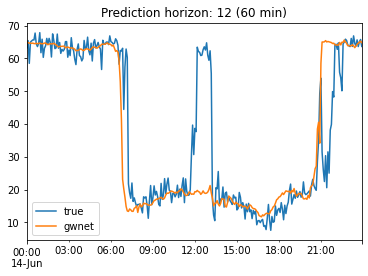

In [8]:
sensor = test.columns[12]
day = '2012-06-14'
data = pd.DataFrame(data = {'true': test.loc[day][sensor], **{method: pred_dfs[method].loc[day][sensor] for method in pred_dfs}})
data.plot(title=f'Prediction horizon: {horizon} ({horizon*5} min)')